# RealNVP Model in PyTorch

This notebook provides a simple implementation of a RealNVP flow model.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.distributions import MultivariateNormal

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

# Create Dataset

The dataset we will use is created by the make_moons function from the Python library sklearn. This create a noisy dataset of points in 2D that resemble two crescents.

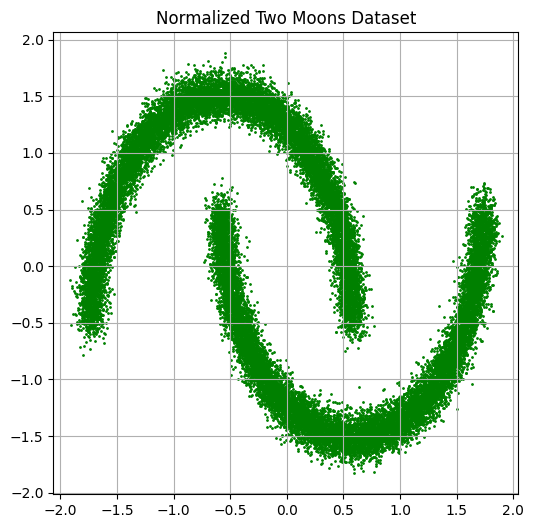

In [20]:
# Generate the two moons dataset
data, _ = make_moons(n_samples=30000, noise=0.05)
data = data.astype("float32")

# Normalize using sklearn's StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
normalized_data = torch.tensor(normalized_data, dtype=torch.float32)

# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], c="green", s=1)
plt.title("Normalized Two Moons Dataset")
plt.axis("equal")
plt.grid(True)
plt.show()

In [ ]:
# Hyperparameters
COUPLING_DIM = 256        # Hidden layer size in the coupling MLP
COUPLING_LAYERS = 2       # Number of hidden layers in each scale/shift network
INPUT_DIM = 2             # Input dimensionality (2D for two moons)
REGULARIZATION = 0.01     # L2 regularization coefficient (used with weight decay)
BATCH_SIZE = 256          # Mini-batch size
EPOCHS = 300              # Number of training epochs

# Coupling Network for RealNVP

In [ ]:
class CouplingMLP(nn.Module):
    """
    Neural network that outputs scale (s) and translation (t) vectors
    for a RealNVP coupling layer.
    """
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()

        # Translation network (output is linear)
        self.t_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)  # linear output
        )

        # Scale network (output is tanh)
        self.s_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  # ensure output scale stays within range
        )

    def forward(self, x):
        """
        Returns the scale (s) and translation (t) outputs for input x.
        """
        s = self.s_net(x)
        t = self.t_net(x)
        return s, t

# RealNVP

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, num_coupling_layers, input_dim=2):
        super().__init__()

        self.num_coupling_layers = num_coupling_layers

        # Prior distribution in latent space
        self.prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))

        # Alternating binary masks, e.g., [0,1], [1,0], ...
        self.masks = torch.tensor(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2),
            dtype=torch.float32
        )

        # Create coupling networks (scale and translate nets)
        self.coupling_layers = nn.ModuleList([
            CouplingMLP(input_dim) for _ in range(num_coupling_layers)
        ])

    def forward(self, x, reverse=False):
        """
        Performs the RealNVP transformation.
        If reverse=False, maps data -> latent space.
        If reverse=True, maps latent space -> data.
        """
        log_det = torch.zeros(x.size(0))
        direction = -1 if not reverse else 1
        layers = range(self.num_coupling_layers)[::direction]

        for i in layers:
            mask = self.masks[i].to(x.device)
            x_masked = x * mask
            s, t = self.coupling_layers[i](x_masked)

            # Only apply scale/translate to unmasked dims
            s = s * (1 - mask)
            t = t * (1 - mask)

            gate = (direction - 1) / 2  # -1 if forward, 0 if reverse

            if reverse:
                x = (x - t) * torch.exp(-s) * (1 - mask) + x_masked
            else:
                x = (x * torch.exp(s) + t) * (1 - mask) + x_masked

            log_det += gate * torch.sum(s, dim=1)

        return x, log_det

    def log_prob(self, x):
        """
        Computes the log-likelihood of the input data.
        """
        z, log_det = self.forward(x, reverse=False)
        log_likelihood = self.prior.log_prob(z) + log_det
        return log_likelihood

    def loss(self, x):
        """
        Negative log-likelihood loss.
        """
        return -self.log_prob(x).mean()

In [ ]:
model = RealNVP(num_coupling_layers=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:

# Assume normalized_data is a (N, 2) torch tensor
dataset = TensorDataset(normalized_data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=256)

In [ ]:
EPOCHS = 1
model.train()

for epoch in range(EPOCHS):
    train_loss = 0.0
    model.train()
    for batch in train_loader:
        x = batch[0].to(device)
        loss = model.loss(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            val_loss += model.loss(x).item() * x.size(0)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss/train_size:.4f} | Val Loss: {val_loss/val_size:.4f}")

Epoch 1/1 | Train Loss: -1.9673 | Val Loss: -4.1406


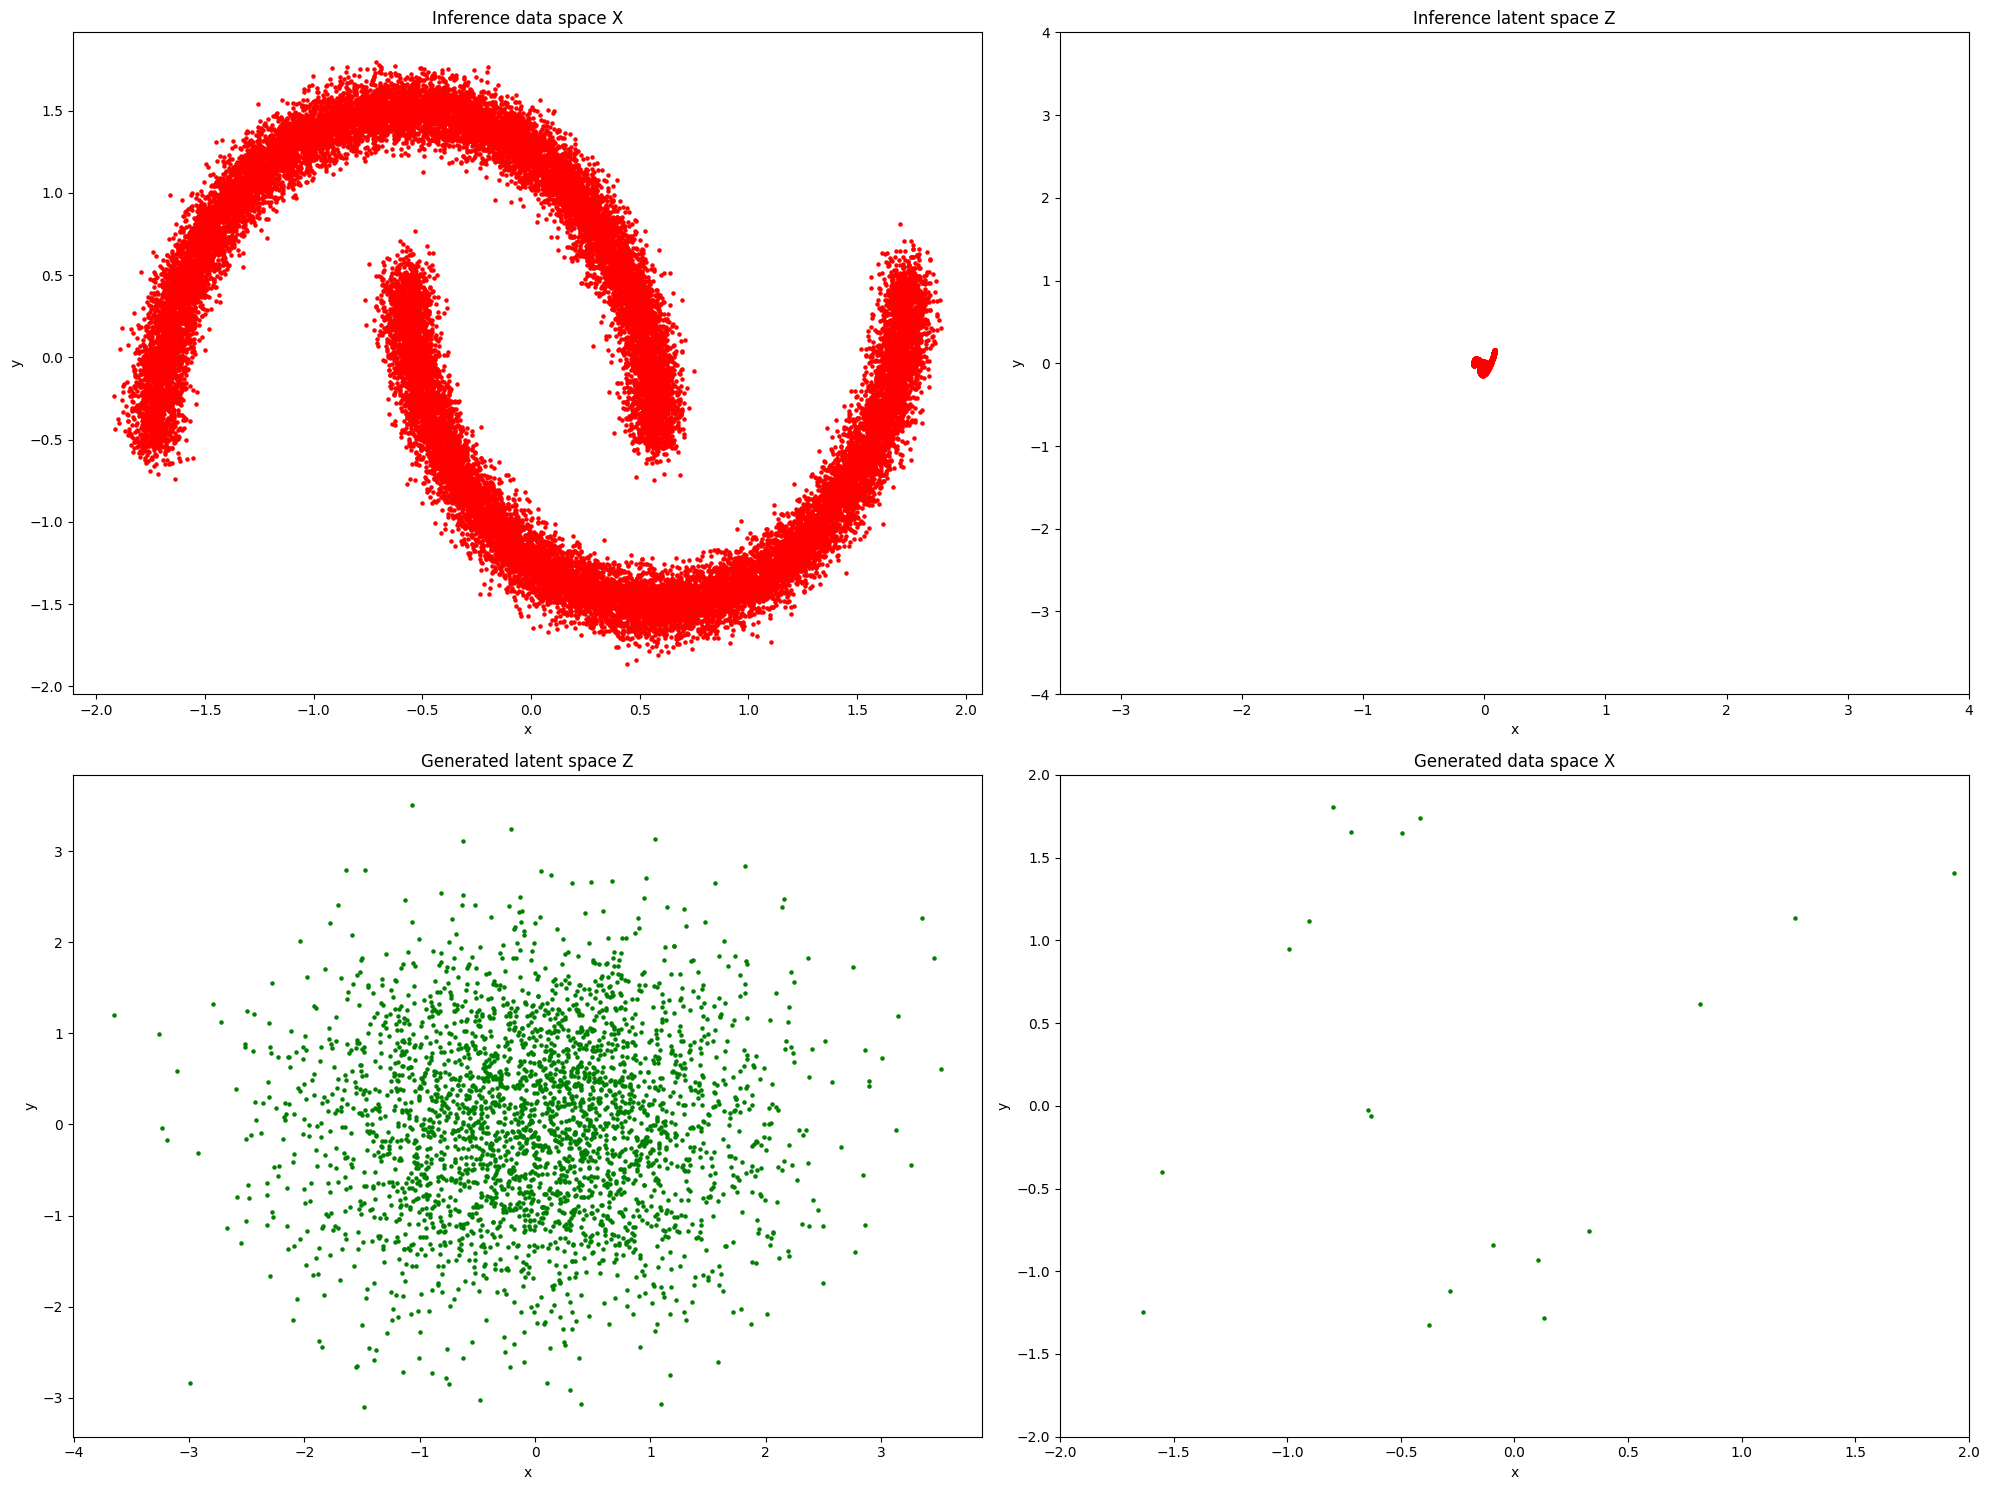

In [18]:
import matplotlib.pyplot as plt

# Plot loss manually if tracked
# (Skip if you didn't store loss during training)

# Inference: X → Z
model.eval()
with torch.no_grad():
    z, _ = model(normalized_data.to(device), reverse=False)
    z = z.cpu().numpy()

# Generation: Z → X
samples = torch.randn(3000, 2).to(device)  # latent samples
with torch.no_grad():
    x_gen, _ = model(samples, reverse=True)
    x_gen = x_gen.cpu().numpy()
    samples = samples.cpu().numpy()

# Plotting
f, axes = plt.subplots(2, 2, figsize=(20, 15))

# Original data
axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r", s=5)
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")

# Encoded latent space
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=5)
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])

# Sampled latent Z
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=5)
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")

# Generated data
axes[1, 1].scatter(x_gen[:, 0], x_gen[:, 1], color="g", s=5)
axes[1, 1].set(title="Generated data space X", xlabel="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])

plt.tight_layout()
plt.show()

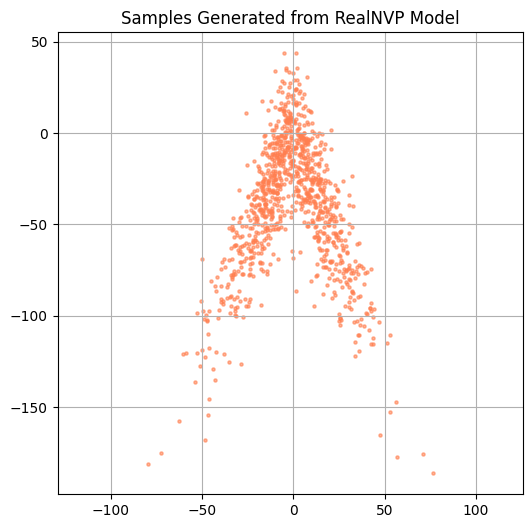

In [ ]:
import matplotlib.pyplot as plt

model.eval()

# Step 1: Sample from base distribution (latent space)
z = torch.randn(1000, 2).to(device)  # <-- This is where the line goes

# Step 2: Pass through RealNVP model in reverse to generate data
with torch.no_grad():
    x_sampled, _ = model(z, reverse=True)
    x_sampled = x_sampled.cpu().numpy()

# Step 3: Visualize
plt.figure(figsize=(6, 6))
plt.scatter(x_sampled[:, 0], x_sampled[:, 1], s=5, alpha=0.6, color='coral')
plt.title("Samples Generated from RealNVP Model")
plt.axis("equal")
plt.grid(True)
plt.show()